Loaded 64313 AGEB rows.
Sample CVEGEO:
0    1000100010054
1    1000100010069
2    1000100010088
3    1000100010092
4    1000100010105
Name: CVEGEO, dtype: object
Shapefile loaded: 64646 polygons.
SHP columns: ['CVEGEO', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'geometry']


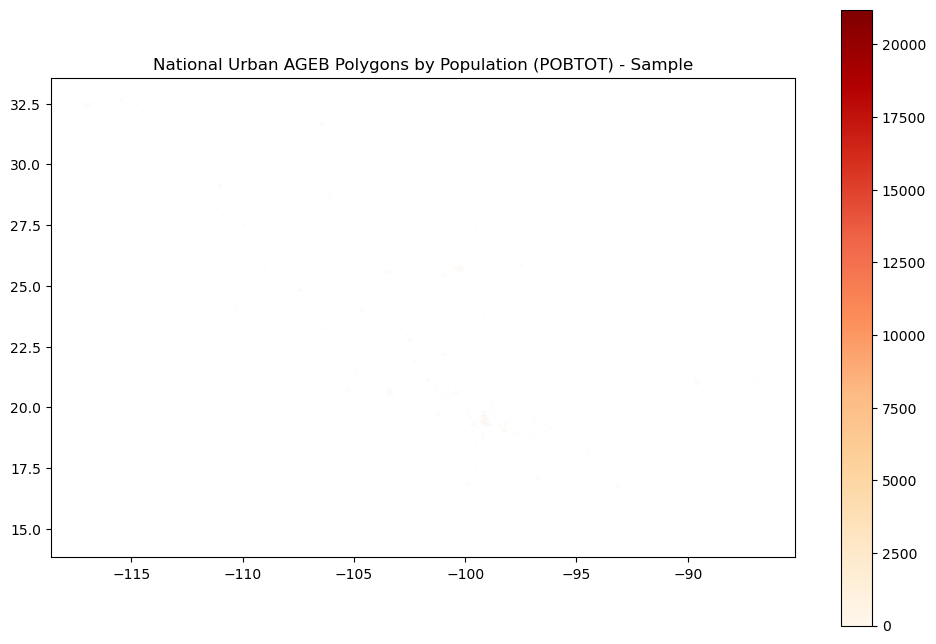

Merged shape: 63616 features (join rate: 98.4%).
Sample merged row:
        join_key         NOM_MUN  POBTOT GRAPROES  \
0  010010001216A  Aguascalientes    2657     10.7   

                                            geometry  
0  POLYGON ((-102.27058 21.87363, -102.27083 21.8...  

Exported to ../data/processed/ageb_merged/national_ageb_geo.parquet.


In [5]:
import pandas as pd
import geopandas as gpd
from pathlib import Path

# Load the national AGEB Parquet from ingestion (updated path to ageb_total subdir)
parquet_path = '../data/processed/ageb_total/national_ageb.parquet'
national_ageb = pd.read_parquet(parquet_path)

print(f"Loaded {len(national_ageb)} AGEB rows.")
print("Sample CVEGEO:")
print(national_ageb['CVEGEO'].head())

# Load the national shapefile (single file for all states; assume .shp extension)
shp_dir = '../data/raw/inegi_shapes/2024_1_00_A'
shp_base = '2024_1_00_A'  # Your base name
shp_path = Path(shp_dir) / f"{shp_base}.shp"
if not shp_path.exists():
    print(f"Shapefile not found at {shp_path}. Check if .shp exists.")
else:
    ageb_shp = gpd.read_file(shp_path)
    ageb_shp = ageb_shp.to_crs('EPSG:4326')  # WGS84 for web maps

    print(f"Shapefile loaded: {len(ageb_shp)} polygons.")
    print("SHP columns:", ageb_shp.columns.tolist())

    # Standardize key: Use CVEGEO if present; align to your Parquet's CVEGEO
    if 'CVEGEO' in ageb_shp.columns:
        ageb_shp['join_key'] = ageb_shp['CVEGEO'].astype(str).str.zfill(13)
    elif 'CVE_AGEB' in ageb_shp.columns:
        # If only CVE_AGEB, construct full from other CVE_* cols (common in INEGI)
        ageb_shp['join_key'] = (
            ageb_shp['CVE_ENT'].astype(str).str.zfill(2) +
            ageb_shp['CVE_MUN'].astype(str).str.zfill(3) +
            ageb_shp['CVE_LOC'].astype(str).str.zfill(4) +
            ageb_shp['CVE_AGEB'].astype(str).str.zfill(4)
        )
    else:
        print("No CVEGEO or CVE_AGEB found—check columns and adjust.")

    # Ensure Parquet key matches
    national_ageb['join_key'] = national_ageb['CVEGEO'].astype(str).str.zfill(13)

    # Merge: Shapes (left) + Stats (inner on join_key)
    ageb_geo = ageb_shp.merge(national_ageb, on='join_key', how='inner')

    # Drop mismatches (e.g., non-urban or NaNs)
    ageb_geo = ageb_geo.dropna(subset=['POBTOT'])  # Stats-loaded rows only

    # Quick viz: Plot subsample for speed (first 5000 or filter by ENT)
    sample_geo = ageb_geo.sample(min(5000, len(ageb_geo)))
    sample_geo.plot(column='POBTOT', cmap='OrRd', legend=True, figsize=(12, 8))
    import matplotlib.pyplot as plt
    plt.title('National Urban AGEB Polygons by Population (POBTOT) - Sample')
    plt.show()

    # Check merge success
    print(f"Merged shape: {len(ageb_geo)} features (join rate: {len(ageb_geo)/len(ageb_shp)*100:.1f}%).")
    print("Sample merged row:")
    print(ageb_geo[['join_key', 'NOM_MUN', 'POBTOT', 'GRAPROES', 'geometry']].head(1))

    # Export to processed (GeoParquet for efficiency)
    output_path = '../data/processed/ageb_merged/national_ageb_geo.parquet'
    Path(output_path).parent.mkdir(exist_ok=True)  # Create subdir if needed
    ageb_geo.to_parquet(output_path, index=False)
    print(f"\nExported to {output_path}.")